In [31]:
#
# Author Jiabao Li
#
# Created on Mon May 27 2024
#
# Copyright (c) 2024 Loctek
#


In [32]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from preprocess import make_dataset, scale_IR, make_dataset_ex
import torch.optim as optim
from model import *
from torch.utils.data import Dataset, DataLoader


In [33]:
class CustomDataset(Dataset):
    def __init__(self, distance_dataset, IR_dataset, ground_truth, filename_dataset):
        self.IR_dataset = IR_dataset
        self.distance_dataset = distance_dataset
        self.ground_truth = ground_truth
        self.filename_dataset = filename_dataset

    def __len__(self):
        return self.IR_dataset.shape[0]

    def __getitem__(self, idx):
        IR_data = self.IR_dataset[idx]
        distance_data = self.distance_dataset[idx]
        label = self.ground_truth[idx]
        # 将标签转换为one-hot编码
        label_one_hot = torch.zeros(LABEL_NUM)
        label_one_hot[label] = 1
        return IR_data, distance_data, label_one_hot, self.filename_dataset[idx]


In [34]:
g_modle_str = 'high'
# g_modle_str = 'low'
# g_modle_extra_str = '3'
g_epoch_count = 200

from datetime import datetime
lean_today = datetime.today()
learn_model_version = "1.0.0"
check_points_dir = f'checkpoints/{g_modle_str}/{lean_today.year}_{lean_today.month}_{lean_today.day}_{lean_today.hour}_{lean_today.minute}_{lean_today.second}/'

# trainset, testset = make_dataset()
trainset, testset = make_dataset_ex(g_modle_str)

# 创建数据集和数据加载器
train_dataset = CustomDataset(*trainset)
test_dataset = CustomDataset(*testset)

# 创建数据加载器
# USE_BACH = BATCH
USE_BACH = 32 # 自定义batch_size
train_dataloader = DataLoader(train_dataset, batch_size=USE_BACH, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=USE_BACH, shuffle=False)


distance length is 1749
IR length is 1749
gt length is 1749
Distance train dataset: torch.Size([42960, 14, 1])
IR train dataset: torch.Size([42960, 9, 64])
gt train dataset: 42960
test dataset has file amount:  torch.Size([350, 14, 1])


In [35]:
labels = trainset[2]
# 计算每个类别出现的次数
num_samples = len(labels)
num_classes = max(labels) + 1  # 假设类别标签从0开始且连续
class_counts = [labels.count(i) for i in range(num_classes)]

# 计算每个类别的权重，使用类别频率的倒数
weights = [num_samples / class_counts[i] if class_counts[i] > 0 else 0 for i in range(num_classes)]

# 转换为Tensor
weights_tensor = torch.tensor(weights).to(mydevice)
print(weights_tensor)

tensor([5.2666, 3.7974, 6.2180, 4.5460, 6.0244], device='cuda:0')


In [36]:

# 实例化网络
net = MyMLP().to(mydevice)
# net = MyCNN().to(mydevice)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

optimizer = optim.Adam(net.parameters(), lr=0.0003)


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
from datetime import datetime
import os
loss_history = []
loss_epoch_history = []
print("if gpu=",torch.cuda.is_available())
          
# 训练循环示例
lr_ = 0.0003

last_modle_file_name = ""
best_recall_modle_file_name = ""
best_acc_modle_file_name = ""
best_pre_modle_file_name = ""
best_recall_score = 0.0
best_acc_score = 0.0
best_pre_score = 0.0


def epoch_test():
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for i, (IR_data, distance_data, labels, filename) in enumerate(test_dataloader):
            IR_data = IR_data.to(mydevice)
            distance_data = distance_data.to(mydevice)

            outputs = net(IR_data, distance_data)
            outputs = outputs.cpu()

            _, predicted = torch.max(outputs.data, 1)
            _, gt = torch.max(labels.data, 1)
            
            true_labels.extend(gt.numpy())
            predicted_labels.extend(predicted.numpy()) 
    return [accuracy_score(true_labels, predicted_labels),precision_score(true_labels, predicted_labels, average='weighted', zero_division=1),recall_score(true_labels, predicted_labels, average='weighted', zero_division=1)]



tmp_next_remain_epochs = g_epoch_count / 2

for epoch in range(g_epoch_count):
    # if (g_epoch_count - epoch) < tmp_next_remain_epochs: # To decrease the learning rate by a factor of ten every half of the training epochs
    #     lr_ /= 10
    if (epoch+1) % 10 == 0:
        lr_ *= 0.9
        optimizer = optim.Adam(net.parameters(), lr=lr_)
        tmp_next_remain_epochs = tmp_next_remain_epochs / 2
    epoch_running_loss = 0.0
    running_loss = 0.0
    epoch_running_cout = 0
    for i, (IR_data, distance_data, labels, _) in enumerate(train_dataloader, 0):
        IR_data = IR_data.to(mydevice)
        distance_data = distance_data.to(mydevice)
        labels = labels.to(mydevice)
        # 清零梯度
        optimizer.zero_grad()

        # 前向传播
        outputs = net(IR_data, distance_data)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 更新权重
        optimizer.step()

        # 打印统计信息
        epoch_running_loss += loss.cpu().item()
        running_loss += loss.cpu().item()
        epoch_running_cout += 1

        if i % 20 == 19:  # 每10个批次打印一次
             loss_mean = running_loss / 20
             loss_history.append(loss_mean)
             print(f"[{epoch + 1}, {i + 1}] loss: {loss_mean:.3f} lr:{lr_:3e}")
             running_loss = 0.0

    if epoch_running_cout > 0:
        epoch_loss_mean = epoch_running_loss / epoch_running_cout
        loss_epoch_history.append(epoch_loss_mean)
        # print(f"[{epoch + 1}] loss: {epoch_loss_mean:.3f} lr:{lr_:3e}")
        # if i % 20 == 19:  # 每10个批次打印一次
        #     loss_mean = running_loss / 20
        #     loss_history.append(loss_mean)
        #     print(f"[{epoch + 1}, {i + 1}] loss: {loss_mean:.3f}")
        #     running_loss = 0.0

    # 测试每一轮输出结构
    # 保存最新一次
    if len(last_modle_file_name)>0 and os.path.exists(last_modle_file_name):
        os.remove(last_modle_file_name)

    if not os.path.exists(check_points_dir):
        os.makedirs(check_points_dir)

    last_modle_file_name = f'{check_points_dir}/last_epoch_{epoch}.pth'
    torch.save(net.state_dict(), last_modle_file_name)

    tmp_epoch_acc,tmp_epoch_pre,tmp_epoch_recall = epoch_test()

    if epoch == 0:
        best_recall_score =tmp_epoch_recall
        best_acc_score =tmp_epoch_acc
        best_pre_score =tmp_epoch_pre
        best_recall_modle_file_name = f'{check_points_dir}/best_recall_{epoch}.pth'
        best_acc_modle_file_name = f'{check_points_dir}/best_acc_{epoch}.pth'
        best_pre_modle_file_name = f'{check_points_dir}/best_pre_{epoch}.pth'
        torch.save(net.state_dict(), best_recall_modle_file_name)
        torch.save(net.state_dict(), best_acc_modle_file_name)
        torch.save(net.state_dict(), best_pre_modle_file_name)
    else:
        if (tmp_epoch_recall > best_recall_score):
            best_recall_score = tmp_epoch_recall
            if len(best_recall_modle_file_name)>0 and os.path.exists(best_recall_modle_file_name):
                os.remove(best_recall_modle_file_name)
            best_recall_modle_file_name = f'{check_points_dir}/best_recall_{epoch}.pth'
            torch.save(net.state_dict(), best_recall_modle_file_name)

        if (tmp_epoch_acc > best_acc_score):
            best_acc_score = tmp_epoch_acc
            if len(best_acc_modle_file_name)>0 and os.path.exists(best_acc_modle_file_name):
                os.remove(best_acc_modle_file_name)
            best_acc_modle_file_name = f'{check_points_dir}/best_acc_{epoch}.pth'
            torch.save(net.state_dict(), best_acc_modle_file_name)

        if (tmp_epoch_pre > best_pre_score):
            best_pre_score = tmp_epoch_pre
            if len(best_pre_modle_file_name)>0 and os.path.exists(best_pre_modle_file_name):
                os.remove(best_pre_modle_file_name)
            best_pre_modle_file_name = f'{check_points_dir}/best_pre_{epoch}.pth'
            torch.save(net.state_dict(), best_pre_modle_file_name)

    


if gpu= True
[1, 20] loss: 8.052 lr:3.000000e-04
[1, 40] loss: 7.970 lr:3.000000e-04
[1, 60] loss: 7.985 lr:3.000000e-04
[1, 80] loss: 8.041 lr:3.000000e-04
[1, 100] loss: 7.994 lr:3.000000e-04
[1, 120] loss: 8.075 lr:3.000000e-04
[1, 140] loss: 8.142 lr:3.000000e-04
[1, 160] loss: 8.074 lr:3.000000e-04
[1, 180] loss: 8.082 lr:3.000000e-04
[1, 200] loss: 8.114 lr:3.000000e-04
[1, 220] loss: 8.010 lr:3.000000e-04
[1, 240] loss: 7.952 lr:3.000000e-04
[1, 260] loss: 7.852 lr:3.000000e-04
[1, 280] loss: 7.991 lr:3.000000e-04
[1, 300] loss: 7.821 lr:3.000000e-04
[1, 320] loss: 7.868 lr:3.000000e-04
[1, 340] loss: 7.728 lr:3.000000e-04
[1, 360] loss: 7.665 lr:3.000000e-04
[1, 380] loss: 7.744 lr:3.000000e-04
[1, 400] loss: 7.649 lr:3.000000e-04
[1, 420] loss: 7.594 lr:3.000000e-04
[1, 440] loss: 7.627 lr:3.000000e-04
[1, 460] loss: 7.636 lr:3.000000e-04
[1, 480] loss: 7.630 lr:3.000000e-04
[1, 500] loss: 7.520 lr:3.000000e-04
[1, 520] loss: 7.561 lr:3.000000e-04
[1, 540] loss: 7.569 lr:3.000

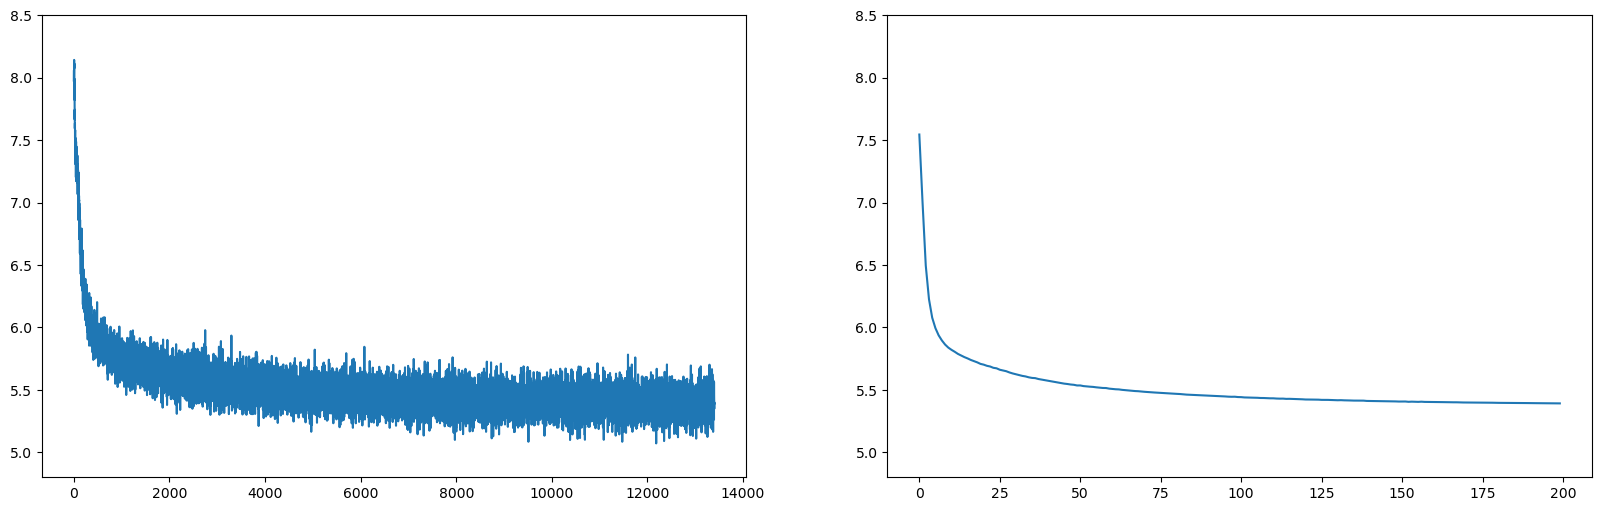

In [38]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.plot(loss_history)
plt.ylim((4.8,8.5))

plt.subplot(122)
plt.plot(loss_epoch_history)
plt.ylim((4.8,8.5))

plt.savefig(f'{check_points_dir}/loss_plot.png', dpi=300)
plt.show()

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 测试循环
true_labels = []
predicted_labels = []
filenames = []
with torch.no_grad():
    for i, (IR_data, distance_data, labels, filename) in enumerate(test_dataloader):
        IR_data = IR_data.to(mydevice)
        distance_data = distance_data.to(mydevice)

        outputs = net(IR_data, distance_data)
        outputs = outputs.cpu()

        _, predicted = torch.max(outputs.data, 1)
        _, gt = torch.max(labels.data, 1)
        
        true_labels.extend(gt.numpy())
        predicted_labels.extend(predicted.numpy())
        filenames += filename

# 计算性能指标
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1) # macro
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=1)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}\n")

# 计算每个类别的精确度和召回率
precision_per_class = precision_score(true_labels, predicted_labels, average=None, zero_division=0)
recall_per_class = recall_score(true_labels, predicted_labels, average=None, zero_division=0)

# 打印结果
print("labels are ", ['idle', 'sit', 'sit2stand', 'stand', 'stand2sit'])
print(f"Precision per class: {precision_per_class}")
print(f"Recall per class: {recall_per_class}\n")

from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predicted_labels)

print("混淆矩阵:")
print(cm)

print("\n")

tmp_test_count = cm.sum()

# 无人判断为有人
idle_err_count  = (cm[1][0] + cm[2][0] + cm[3][0] + cm[4][0])
print(f"有人判断为无人的异常概率：{idle_err_count/tmp_test_count:.4f}")

no_idle_err_count  = (cm[0][1] + cm[0][2] + cm[0][3] + cm[0][4])
print(f"无人判断为有人的异常概率：{no_idle_err_count/tmp_test_count:.4f}")

 
if g_modle_str is 'low':
    # 若是低位模型 - 其他类型误识别为站
    low_err_count = (cm[0][3] + cm[1][3] + cm[2][3] + cm[4][3])
    print(f"其他类型误识别成站：{ low_err_count/tmp_test_count:.4f}")

if g_modle_str is 'high':
    # 若是高位模型 - 其他类型误识别为坐
    high_err_count = (cm[0][1] + cm[2][1] + cm[3][1] + cm[4][1])
    print(f"其他类型误识别成坐：{ high_err_count/tmp_test_count:.4f}")

Accuracy: 0.9629
Precision: 0.9635
Recall: 0.9629

labels are  ['idle', 'sit', 'sit2stand', 'stand', 'stand2sit']
Precision per class: [0.95294118 1.         0.94736842 0.95774648 0.94642857]
Recall per class: [1.         0.95294118 0.98181818 0.91891892 0.96363636]

混淆矩阵:
[[81  0  0  0  0]
 [ 0 81  1  0  3]
 [ 0  0 54  1  0]
 [ 4  0  2 68  0]
 [ 0  0  0  2 53]]


有人判断为无人的异常概率：0.0114
无人判断为有人的异常概率：0.0000
其他类型误识别成坐：0.0000


In [40]:
# 找出被错误分类的样本
misclassified_samples = [filenames[i] for i in range(len(filenames)) if true_labels[i] != predicted_labels[i]]
print("被错误分类的样本:", misclassified_samples)

被错误分类的样本: ['../data/high-position-sit/new章苗_高位_坐姿_1718850846', '../data/high-position-stand/new0620-3_高位_站姿_1718871572', '../data/high-positon-stand2sit/new姜梦帆_高位_站姿到坐姿_1718257377', '../data/high-position-sit2stand/new陈翊_高位_坐姿到站姿_1718087811', '../data/high-position-stand/newxusheng_高位_站姿_1717739866', '../data/high-position-sit/new章苗_高位_坐姿_1718850868', '../data/high-position-stand/new0620-3_高位_站姿_1718871673', '../data/high-position-stand/new黄镓辉_高位_站姿_1718168759', '../data/high-position-sit/new姜梦帆_高位_坐姿_1718257177', '../data/high-position-stand/new黄镓辉_高位_站姿_1718168765', '../data/high-positon-stand2sit/new张世杰_高位_站姿到坐姿_1718171716', '../data/high-position-sit/new章苗_高位_坐姿_1718850891', '../data/high-position-stand/newxusheng_高位_站姿_1717739860']


In [41]:
import shutil
import os
from datetime import datetime
from pathlib import Path

# 创建目标文件夹
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
target_folder = os.path.join("wrongs", timestamp)
os.makedirs(target_folder, exist_ok=True)

# 复制被错误分类的样本到目标文件夹
for filename in misclassified_samples:
    # 假设原始文件位于当前文件夹中
    # folder, sample_id = filename.split('_')
    source_path = f'{filename}.mp4' # Path('..') / 'data_v2' / folder / f'{sample_id}.mp4'
    # target_path = os.path.join(target_folder, os.path.basename(filename))
    shutil.copy(source_path, target_folder)

print(f"被错误分类的样本已复制到 {target_folder}")


被错误分类的样本已复制到 wrongs/20240620-202938


In [42]:
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")

Total parameters: 3165


In [43]:
# from datetime import datetime
# # 获取当前日期和时间
# today = datetime.today()
# modle_file_name = f'checkpoints/{g_modle_str}/AllData_{today.month}_{today.day}_{g_modle_str}_balanced_{g_modle_extra_str}.pth'
# print(f'file_name:{modle_file_name}')
# torch.save(net.state_dict(), modle_file_name)

In [44]:
from pth_converter import save_params_to_txt

# # 使用示例
# model_path = 'models\checkpoints\low\AllData_6_11_low_balanced_0d90_3.pth'  # 模型文件路径
output_file = f'{last_modle_file_name[:-3]}txt'  # 输出文件路径
save_params_to_txt(last_modle_file_name, output_file, g_modle_str, op_declares = False)


output_file = f'{best_recall_modle_file_name[:-3]}txt'  # 输出文件路径
save_params_to_txt(best_recall_modle_file_name, output_file, g_modle_str, op_declares = False)

output_file = f'{best_pre_modle_file_name[:-3]}txt'  # 输出文件路径
save_params_to_txt(best_pre_modle_file_name, output_file, g_modle_str, op_declares = False)

output_file = f'{best_acc_modle_file_name[:-3]}txt'  # 输出文件路径
save_params_to_txt(best_acc_modle_file_name, output_file, g_modle_str, op_declares = False)

In [45]:
# 衡量所有导出模型
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import shutil
import os
from datetime import datetime
from pathlib import Path

test_result_dict = {}

def model_test(_model_file_name:str):
    print(f"模型：{_model_file_name}")
    _model_base_name =os.path.splitext(os.path.basename(_model_file_name))[0]
    # 创建类
    eval_net = MyMLP().to(mydevice)
    # 加载模型
    eval_net.load_state_dict(torch.load(_model_file_name))
    # eval 模式
    eval_net.eval()


    # 测试循环
    true_labels = []
    predicted_labels = []
    filenames = []
    with torch.no_grad():
        for i, (IR_data, distance_data, labels, filename) in enumerate(test_dataloader):
            IR_data = IR_data.to(mydevice)
            distance_data = distance_data.to(mydevice)

            outputs = eval_net(IR_data, distance_data)
            outputs = outputs.cpu()

            _, predicted = torch.max(outputs.data, 1)
            _, gt = torch.max(labels.data, 1)
            
            true_labels.extend(gt.numpy())
            predicted_labels.extend(predicted.numpy())
            filenames += filename

    # 计算性能指标
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1) # macro
    recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=1)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}\n")

    # 计算每个类别的精确度和召回率
    precision_per_class = precision_score(true_labels, predicted_labels, average=None, zero_division=0)
    recall_per_class = recall_score(true_labels, predicted_labels, average=None, zero_division=0)

    # 打印结果
    print("labels are ", ['idle', 'sit', 'sit2stand', 'stand', 'stand2sit'])
    print(f"Precision per class: {precision_per_class}")
    print(f"Recall per class: {recall_per_class}\n")

    # 计算混淆矩阵
    cm = confusion_matrix(true_labels, predicted_labels)

    print("混淆矩阵:")
    print(cm)

    print("\n")

    tmp_test_count = cm.sum()

    # 无人判断为有人
    idle_err_count  = (cm[1][0] + cm[2][0] + cm[3][0] + cm[4][0])
    print(f"有人判断为无人的异常概率：{idle_err_count/tmp_test_count:.4f}")

    no_idle_err_count  = (cm[0][1] + cm[0][2] + cm[0][3] + cm[0][4])
    print(f"无人判断为有人的异常概率：{no_idle_err_count/tmp_test_count:.4f}")

    test_each_result_dict = {"Accuracy":accuracy,"Precision":precision,"Recall":recall}
    test_each_result_dict["有人判断为无人"] = idle_err_count/tmp_test_count
    test_each_result_dict["无人判断为有人"] = no_idle_err_count/tmp_test_count
    if g_modle_str is 'low':
        # 若是低位模型 - 其他类型误识别为站
        low_err_count = (cm[0][3] + cm[1][3] + cm[2][3] + cm[4][3])
        print(f"其他类型误识别成站：{ low_err_count/tmp_test_count:.4f}")
        test_each_result_dict["其他类型误识别成站"] = low_err_count/tmp_test_count

    if g_modle_str is 'high':
        # 若是高位模型 - 其他类型误识别为坐
        high_err_count = (cm[0][1] + cm[2][1] + cm[3][1] + cm[4][1])
        print(f"其他类型误识别成坐：{ high_err_count/tmp_test_count:.4f}")
        test_each_result_dict["其他类型误识别成坐"] = high_err_count/tmp_test_count


    # 找出被错误分类的样本
    misclassified_samples = [filenames[i] for i in range(len(filenames)) if true_labels[i] != predicted_labels[i]]
    print("被错误分类的样本:", misclassified_samples)

    # 创建目标文件夹
    timestamp = lean_today.strftime("%Y%m%d-%H%M%S")
    target_folder = os.path.join("wrongs", timestamp, _model_base_name)
    os.makedirs(target_folder, exist_ok=True)

    # 复制被错误分类的样本到目标文件夹
    for filename in misclassified_samples:
        # 假设原始文件位于当前文件夹中
        # folder, sample_id = filename.split('_')
        source_path = f'{filename}.mp4' # Path('..') / 'data_v2' / folder / f'{sample_id}.mp4'
        # target_path = os.path.join(target_folder, os.path.basename(filename))
        shutil.copy(source_path, target_folder)

    print(f"被错误分类的样本已复制到 {target_folder}")  

    test_each_result_dict["wrongs"] = misclassified_samples
    test_result_dict[_model_base_name] = test_each_result_dict

    

model_test(last_modle_file_name)
model_test(best_acc_modle_file_name)
model_test(best_pre_modle_file_name)
model_test(best_recall_modle_file_name)


test_result_dict["version"] = learn_model_version
test_result_dict["date"] = lean_today.isoformat()

import json
json_str = json.dumps(test_result_dict,indent=4, ensure_ascii=False)

with open(f'{check_points_dir}/info.json', 'w') as file:
    file.write(json_str+ '\n')


模型：checkpoints/high/2024_6_20_20_25_29//last_epoch_199.pth
Accuracy: 0.9629
Precision: 0.9635
Recall: 0.9629

labels are  ['idle', 'sit', 'sit2stand', 'stand', 'stand2sit']
Precision per class: [0.95294118 1.         0.94736842 0.95774648 0.94642857]
Recall per class: [1.         0.95294118 0.98181818 0.91891892 0.96363636]

混淆矩阵:
[[81  0  0  0  0]
 [ 0 81  1  0  3]
 [ 0  0 54  1  0]
 [ 4  0  2 68  0]
 [ 0  0  0  2 53]]


有人判断为无人的异常概率：0.0114
无人判断为有人的异常概率：0.0000
其他类型误识别成坐：0.0000
被错误分类的样本: ['../data/high-position-sit/new章苗_高位_坐姿_1718850846', '../data/high-position-stand/new0620-3_高位_站姿_1718871572', '../data/high-positon-stand2sit/new姜梦帆_高位_站姿到坐姿_1718257377', '../data/high-position-sit2stand/new陈翊_高位_坐姿到站姿_1718087811', '../data/high-position-stand/newxusheng_高位_站姿_1717739866', '../data/high-position-sit/new章苗_高位_坐姿_1718850868', '../data/high-position-stand/new0620-3_高位_站姿_1718871673', '../data/high-position-stand/new黄镓辉_高位_站姿_1718168759', '../data/high-position-sit/new姜梦帆_高位_坐姿_1718257177